## Homework

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv:

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 



In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
df = pd.read_csv(url)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure',  'dependents', 'months', 'majorcards', 'active']
categorical = ['owner','selfemp']

## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [4]:
#Convert `yes` to 1 and `no` to 0
df.card = df.card =='yes'
df.card

0        True
1        True
2        True
3        True
4        True
        ...  
1314     True
1315    False
1316     True
1317     True
1318     True
Name: card, Length: 1319, dtype: bool

In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [6]:
len(df_train),len(df_val),len(df_test)

(791, 264, 264)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`


In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


* `The share variable has the highest AUC`


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [13]:

score = roc_auc_score(y_val, y_pred)
round(score,3)

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

In [15]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores




In [16]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [17]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

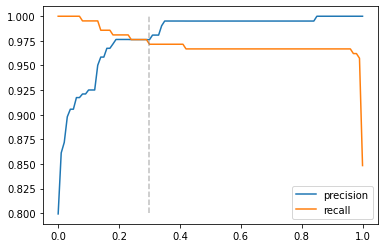

In [24]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.3, 0.8, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()

plt.show()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [25]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

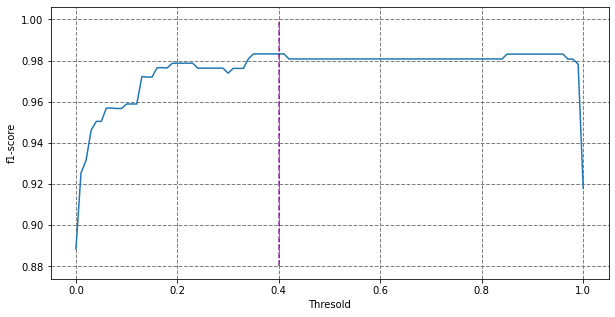

In [46]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.grid(color='gray',linestyle='--', linewidth=1)
plt.vlines(0.4, 0.88, 1, color='purple', linestyle='--', alpha=0.8)


plt.xlabel('Thresold')
plt.ylabel('f1-score')
plt.show()

At which threshold F1 is maximal?

*Answer*: 0.4

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [47]:
from sklearn.model_selection import KFold

In [48]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [50]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


How large is standard devidation of the scores across different folds?

Answer: 0.003

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

In [54]:
C_choices = [0.01, 0.1, 1, 10]

global_scores = []

for C in C_choices:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
       


C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003


Which C leads to the best mean score?

Answer: 1. Also, 10. Both have same score and std.